In [51]:
%matplotlib inline
from collections import Counter
from math import exp
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_integer_dtype
# import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt


In [14]:
dt = pd.read_csv('./data/FreshWaterFishing_RecreationDemand.csv')
dt.head()

,HUC_12,FF_Demand
0,10100020101,181.420650
1,10100020102,123.900172
2,10100020103,192.158172
3,10100020104,94.212300
4,10100020105,327.686424


In [5]:
# fake1 = [1990 for i in range(0, 40)]
fake1 = np.linspace(0, 40, 40, dtype=int)
# fake1
# replace_at = 
# np.random.random_integers(1,5)
print(fake1)
replace_at = np.random.randint(0, 40, size=10)
for i in range(0, len(fake1)):
    if(i in replace_at):
        fake1[i] = np.random.randint(0, 40)
print(fake1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40]
[ 1  1  2  3  4  5  6  7 17  9 10 11 12 13 14 15  3 17 18  5 20 21 22 28
  5 25 26 27 28 12 30 31 32 33 34 39 36 37 38 40]


In [15]:
col1 = dt['FF_Demand']

In [7]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.uniform, st.norm, st.expo]
#     DISTRIBUTIONS = [st.linregress]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data) #TODO Study return parameters for different distributions

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

/Users/gourabmi/Documents/workspace/infer_columns/venv3/lib/python3.6/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


lognorm , (1.6784547172056699, -9.01587629422168, 1923.5811645322624), <scipy.stats._continuous_distns.lognorm_gen object at 0x113d89f28>


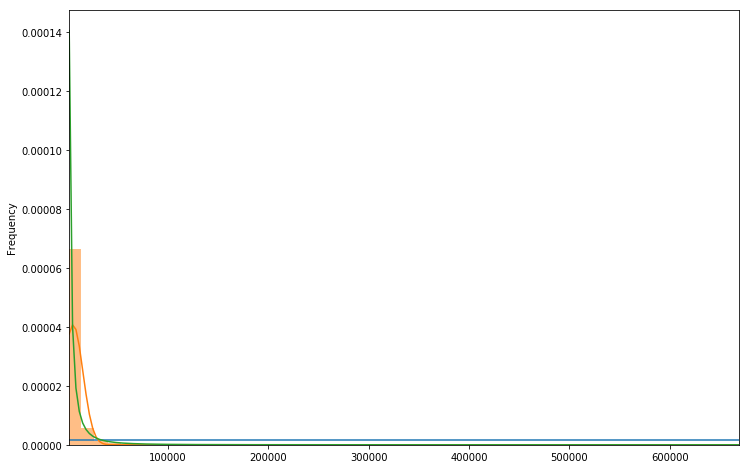

In [16]:
# Load data from statsmodels datasets
# data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
# data = pd.Series(fake1)
data = pd.Series(col1)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)
print("{0} , {1}, {2}".format(best_fit_name, best_fir_paramms, best_dist ))

In [52]:
def kl_div_scipy(p,q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    return st.entropy(p,q)

def my_kl_divergence(p,q):
    """ Returns Kl Divergence of two integer lists. Theory at https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained
    :type p: List[int]
    :type q: List[int]
    :rtype: double
    """
    cf1, l1 = Counter(p), len(p)
    cf2, l2 = Counter(q), len(q)
    # Pre-processing for using KL Divergence of Frequency Counters cf1 and cf2
    s = set(cf1.keys())
    s = s.intersection(cf2.keys()) # Collecting all unique elements in cf1 and cf2
    # Normalizing the series to reflect probabilities of occurence
    for e in list(cf1): # Since we can't iterate over a mutable collection undergoing change
        if e in s:
            cf1[e] = float(cf1[e]/l1)
        else:
            cf1.pop(e, None)
    for f in list(cf2):
        if f in s:
            cf2[f] = float(cf2[f]/l2)
        else:
            cf2.pop(f, None)
    lib_val = kl_div_scipy(list(cf1.values()),list(cf2.values()))
    return lib_val

def score_with_normal(dst):
    lower, upper = np.min(dst), np.max(dst)
    mu, sigma = np.mean(dst), np.std(dst)
    # s = np.random.truncnorm(mu, sigma, len(dst)) # TODO How many points to sample ?
    s = st.truncnorm(a = (lower - mu) / sigma, b = (upper - mu) / sigma, loc=mu, scale=sigma).rvs(len(dst))
    s = s.round().astype(int)
    return my_kl_divergence(dst, s)

def score_with_lognorm(dst):
    mu, sigma = np.mean(dst), np.std(dst)
    u = st.lognorm(s = mu, loc=0, scale=np.exp(mu))
    return my_kl_divergence(dst, u.cdf(dst))

In [54]:
mu, sigma = np.mean(data), np.std(data)
u = st.lognorm(s = mu, loc=0, scale=exp(mu))
list(u.pdf(data))

# print(score_with_lognorm(data))
# print(score_with_normal(np.exp(data))
# data_exp = np.exp(data)
# data_exp = data_exp[~data_exp.isnull()]
# print(score_with_normal(data_exp))

OverflowError: math range error